In [ ]:
# Compute the land-sea contrast in terms of skin temperature using the regions defined in Portal et al. (2022). 
# Here we start with tas as a surface temperature variable. We consider one single member for each model. For the time periods we take 
# 1979-2008 for the historical and 2071-2100 for the future scenario SSP5-8.5.
# The LSC values used for the simulations of Portal et al. (2022) are compared to those computed in 1979-2008 and in 2200-2300 in RCP8.5.

# Caption of fig 2 of Portal et al. (2022):
# Longitude–latitude boxes used to compute LSCPac(B - A) and LSCAtl(D - C). The boxes are between latitudes 40° and 60°N and are 40° longitude wide 
# (box A: 95°–135°E, box B: 150°–190°E, box C: 65°–105°W, box D: 15°–55°W).

In [1]:
#import xesmf as xe
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
from scipy.interpolate import griddata
import matplotlib as mpl
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import cartopy.crs as ccrs

ERROR 1: PROJ: proj_create_from_database: Open of /net/nfs/tools/u20/Python/miniconda3_py311_23.11.0-2/envs/pangeo-meso-2024.01.22/share/proj failed


In [2]:
path2era5 = '/bdd/ERA5/NETCDF/GLOBAL_025/1xmonthly/AN_SF/' # Soil Moisture is not already downloaded, but here the t2m, sstk and msl monthly fields are available.
path2cmip6 = '/bdd/CMIP6/CMIP/'

In [3]:
# Read a single ERA5 file to get the coordinates and the seamask for the coastlines.
ds_era5 = xr.open_dataset(path2era5+'2020/sstk.2020.asme5.GLOBAL_025.nc')
lon = ds_era5.longitude.values
lat = ds_era5.latitude.values

era5_field = ds_era5['sstk'][0]
seamask = era5_field/era5_field
np.nan_to_num(seamask, copy=False, nan=0.0)
# cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])

# minlon, maxlon, minlat, maxlat.
#extent = [360-110, 360-90, 30, 50] # Area of interet in CONUS, defined in Teng et al. (2019)
# Areas defined in Portal et al. (2022)
ext_A = [95, 135, 40, 60]
ext_B = [150, 190, 40, 60]
ext_C = [360-105, 360-65, 40, 60]
ext_D = [360-55, 360-15, 40, 60]

In [4]:
# Define the season of interest.
label_season = 'JJA'
month_number = 1 # 7 is July

In [ ]:
# Test figure
fig = plt.figure(figsize=(14,6))
pc = plt.pcolor(lon,lat,era5_field,shading='nearest')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)# Compute for each model the anomaly with respect to the MMM, for the specified season.
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('Example of ERA5 skin SST [K]',fontsize=16)
plt.savefig('skin_SST_ERA5_portal_etal_2022_boxes.png',bbox_inches='tight')

In [5]:
# Now compute the MMM of tas and its standard deviation in the historical period 1979-2008 and in the future SSP5-8.5 period 2071-2100.
# Define the variable of interest and its units and range of validity.

varname = 'tas' # We can compute its trend and compare it to the MMM with fig1 here https://www.nature.com/articles/s41612-023-00410-6 (Zhang et al., npjCAS, 2023)
domain = 'Amon'
varname_path = 'tas'
description = '2m air temperature'
units = 'K'
n_colors = 11
levels = np.arange(235,325,10)
levels_MMbias = np.arange(-11,13,2)
nan_limit = 450e3

varname = 'tsl'
domain = 'Lmon'
varname_path = 'tsl'
description = 'soil temperature'
units = 'K'
levels = np.arange(235,325,10)
levels_MMbias = np.arange(-11,13,2)
nan_limit = 1e7


varname = 't1m'
domain = 'Lmon'
varname_path = 'tsl'
description = '1m interpolated soil temperature'
units = 'K'
levels = np.arange(235,325,10)
levels_MMbias = np.arange(-11,13,2)
nan_limit = 1e7
vmin = 260
vmax = 310
n_colors = 10

varname = 'mrsos'
domain = 'Lmon'
varname_path = 'mrsos'
description = '10 cm soil moisture'
units = 'kg/m2'
levels = np.arange(0,42,3)
levels_MMbias = np.arange(-15,18,3)
nan_limit = 1e7
vmin = 0
vmax = 39
n_colors = 10

"""
varname = 'tos'
domain = 'Omon'
varname_path = 'tos'
description = 'surface ocean temperature'
units = '°C'
vmin=0
delta=3
n_colors = 11
vmax=delta*n_colors
levels = np.arange(vmin,vmax+delta,delta)
levels_MMbias = np.arange(-11,13,2)
nan_limit = 1e7
"""
cmap = cm.get_cmap('viridis',n_colors)

/tmp/ipykernel_2466914/2553589822.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis',n_colors)


In [ ]:
# GISS-E2-1-G has nans everywhere, except on the borders - check i, index 21.
# E3SM-1-0 has zero tos over land - we could multiply the ERA5 seamask, index 25.
# KACE-1-0-G  has a longitude mismatch, because the continents do not align with the ERA5 coastlines - check it, index 28.

In [ ]:
def get_anomaly_tos(ds_i,extent): # extent: minlon, maxlon, minlat, maxlat
    lon_i = ds_i.longitude.values
    lat_i = ds_i.latitude.values

    ext = [0,0,0,0]
    ext[0] = np.where(lon_i==extent[0])[0][0]
    ext[1] = np.where(lon_i==extent[1])[0][0]
    ext[2] = np.where(lat_i==extent[2])[0][0]
    ext[3] = np.where(lat_i==extent[3])[0][0]

    anomaly = ds_i.isel(longitude=slice(ext[0],ext[1]),latitude=slice(ext[3],ext[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
    return anomaly        

In [6]:
# Consider the same list of models as in 02.mmm_mmbias_single_member, so that the link with the mrsos models can be easily done.
# Compute the seasonal mean considering only the models used for the mrsos MMM.
# Also compute the LSC in the two basins for each model. We need it to compute their pdf and see whether it correlates with the mrsos.

# 20241111, I need to combine each model field and then compute the nanmean, to take into account the differences along coastlines and similar.

time_window = '1979-2008'
counter = 0
first_field = 1

A_list = []
B_list = []
C_list = []
D_list = []
effective_models = []
soil_depth_coord = []
soil_depth_value = []

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv('~/02.mmm_mmbias_single_member/'+label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]

    if os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gr/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gr/latest/'
    elif os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gr1/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gr1/latest/'
    elif os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gn/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files_etal = sorted(os.listdir(path2files))
        # Select only the files that end with 'nc'.
        list_of_files = [idx for idx in list_of_files_etal if idx[-2:].lower() == 'nc'.lower()]

        if list_of_files: # Check whether there are output files to be read.
            print(path2members)
            print(member)

            first_file = 1 
            for ll in range(len(list_of_files)):
                filename = list_of_files[ll]
                final_date = filename[-9:-3]
                #print(filename)
                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                    da = xr.open_dataset(path2files + filename)

                    if varname=='t1m':
                        # Get the coordinate of the depth of the soil layer and save its value.
                        coord_list = []
                        for key in da.coords:
                            coord_list.append(key)
    
                        print(coord_list)
                        for cc in range(len(coord_list)):
                            if len(coord_list)>4:
                                isdepth=4
                            else:
                                if coord_list[cc]!='lon' and coord_list[cc]!='lat' and coord_list[cc]!='time':
                                    isdepth = cc                    
                        
                        soil_depth_coord.append(coord_list[isdepth])
                        soil_depth_value.append(da[coord_list[isdepth]].values)
                        
                    #print(da[coord_list[2]].values) # print the values of soil layer depths

                    # Read the variable of interest, so that the reading is faster.
                    if varname=='z500': # Select the variable at the right pressure level.
                        da_var = da['zg'].sel(plev=50000,method='nearest')
                    elif varname=='z200':
                        da_var = da['zg'].sel(plev=20000,method='nearest')
                    elif varname=='tsl':
                        da_var = da[varname][:,0,:,:] # Select the upper level - the soil depth layer are different among models.
                    elif varname=='t1m': # Soil temperature interpolated at 1m depth.
                        sds = da[coord_list[isdepth]].values # Select soil depth coordinate
                        #print(coord_list[isdepth]) 
                        #print(sds)
                        jj = np.argmin(np.abs(sds-1))
                        sds[jj]
                        if sds[jj]<1:
                            j0 = jj # upper layer (above 1 m)
                            j1 = jj+1 # lower layer (below 1m)
                        else:
                            j0 = jj-1
                            j1 = jj
                        print(j0,j1)
                        tj0 = da['tsl'][:,j0,:,:]
                        tj1 = da['tsl'][:,j1,:,:]
                        dt = tj1-tj0
                        dz = sds[j1]-sds[j0]
                        
                        da_var = tj0 + (1-sds[j0])*dt/dz # linear interpolation of soil temperature at 1m depth.
                        #print(da_var)
                    else:
                        da_var = da[varname]

                    if first_file:
                        db = da_var
                        first_file = 0
                    else:
                        db = xr.concat([db,da_var],dim='time')
                    
            # Select the time window according to the type of time axis.
            if db.time.dtype=='datetime64[ns]':
                instant_start = np.datetime64('1979-01-01')
                instant_end = np.datetime64('2008-12-31')
            else:
                print(db.time.values[0].calendar)
                if db.time.values[0].calendar=='noleap':
                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.DatetimeNoLeap(2008,12,31,0,0,0,0,has_year_zero=True)
                elif db.time.values[0].calendar=='360_day':
                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.Datetime360Day(2008,12,17,0,0,0,0,has_year_zero=True)     

            # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
            d_month = d_time.groupby('time.month').mean('time').sel(month=month_number) # Select a month, as well.
            
            if varname=='tos': # Ocean variables are on an irregular grid (often it is tripolar).   
                if len(d_season.dims)>1: # Skip the unstructured grid for now ###################################################
                    if model=='KACE-1-0-G':
                        d_season = d_season.rename({'lon':'old_lon','lat':'old_lat'})
                        d_season = d_season.rename({'longitude':'lon','latitude':'lat'})
                    else:
                        name_coordinates = np.array(d_season.coords).tolist() # Get the names of the coordinates.
                        #print(d_season.coords)
                        select_lat = [idx for idx in name_coordinates if 'lat' in idx]
                        name_lat = select_lat[0]
                        select_lon = [idx for idx in name_coordinates if 'lon' in idx]
                        name_lon = select_lon[0]
                        #name_lat = name_coordinates[0] 
                        #name_lon = name_coordinates[1]
                        d_season = d_season.rename({name_lon:'lon',name_lat:'lat'})
                    #print(d_season.coords)
                    regridder = xe.Regridder(d_season,ds_era5,"bilinear",ignore_degenerate=True)
                    d_season_i = regridder(d_season) # Interpolate.
                    if model=='GISS-E2-1-G':
                        d_season_i -= 273.15 # Convert K to degC, only for this model.
                    # ATTENTION!!! If this condition is not respected the d_season_i of the previous model is used!!!!!!!!!!!!!!!!
                else:
                    print('===== This model has an unstructured grid =====')
                    print('===== We are using data from the previous one =====')
            else:                
                d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                d_month_i = d_month.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
            
            if np.sum(np.isnan(d_season_i.values))<nan_limit: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.

                if varname=='t1m':
                    # Drop the depth of the soil layer, so that we can concat all the models.
                    d_season_i = d_season_i.drop_vars(coord_list[isdepth])
                    d_month_i = d_month_i.drop_vars(coord_list[isdepth])
                elif varname=='mrsos':
                    # Drop the depth of the soil layer, so that we can concat all the models.
                    coord_list = []
                    for key in d_season_i.coords:
                        coord_list.append(key)
                    print(coord_list)
                    if len(coord_list)>5:
                        d_season_i = d_season_i.drop_vars('depth')
                        d_month_i = d_month_i.drop_vars('depth')
                    
                if first_field:
                    d_mean4MMM_seasonal = d_season_i
                    d_mean4MMM_monthly = d_month_i
                    first_field=0
                else:
                    #d_mean4MMM_seasonal += d_season_i
                    #d_mean4MMM_seasonal = np.nansum(d_season_i,d_mean4MMM_seasonal)
                    d_mean4MMM_seasonal = xr.concat([d_mean4MMM_seasonal,d_season_i],'mod')
                    d_mean4MMM_monthly = xr.concat([d_mean4MMM_monthly,d_month_i],'mod')
                counter += 1
                #print(d_season_i) # The depth of the first layer of soil is different in different models.
                
                # Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
                fig = plt.figure(figsize=(14,6))
                #pc = plt.contourf(lon,lat,d_season_i.values,levels=levels)#,cmap='RdYlBu')
                pc = plt.pcolormesh(lon,lat,d_season_i.values,vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
                #pc = plt.pcolormesh(lon,lat,d_season_i.values,cmap=cmap,shading='nearest')
                cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                # Plot the Portal et al. (2022) boxes
                plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
                plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
                plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
                plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

                plt.title(model+' ' + label_season + ' (1 member) '+description+' ['+units+']',fontsize=16)
                #plt.savefig(model+'_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')
                
                # Compute the LSC for a given model
                if varname=='tos': # For 'tos', the method 'sel' works as the method 'isel', i.e. it considers the indices.
                    #anom_A = d_season_i.sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[2],ext_A[3])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    #anom_B = d_season_i.sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[2],ext_B[3])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    #anom_C = d_season_i.sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[2],ext_C[3])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    #anom_D = d_season_i.sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[2],ext_D[3])).mean('longitude',skipna=True).mean('latitude',skipna=True).values                    
                    # For some reasons, the sel method here works as the isel one, i.e. it exploits the indices and not the values of the coordinates.
                    # Thus, we need to do it explicitly, as implemented in the function get_anomaly_tos.
                    anom_A = get_anomaly_tos(d_season_i,ext_A)
                    anom_B = get_anomaly_tos(d_season_i,ext_B)
                    anom_C = get_anomaly_tos(d_season_i,ext_C)
                    anom_D = get_anomaly_tos(d_season_i,ext_D)
                else:
                    anom_A = d_season_i.sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    anom_B = d_season_i.sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    anom_C = d_season_i.sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    anom_D = d_season_i.sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                A_list.append(anom_A)
                B_list.append(anom_B)
                C_list.append(anom_C)
                D_list.append(anom_D)
                effective_models.append(model)
                #print(anom_A,anom_B,anom_C,anom_D)
        print('----------')

print('Number of members actually used in total: '+ str(counter))

##### 'tos' #####

# A couple of links to handle the tripolar grids.
# https://xesmf.readthedocs.io/en/stable/notebooks/Curvilinear_grid.html
# https://github.com/JiaweiZhuang/xESMF/issues/78

# There is one model, among those considered here, with an unstructured grid for the ocean: /AWI/AWI-ESM-1-1-LR/
# For the moment we don't care, but griddata can handle unstructured grids (to be refined):
"""
test = d_season.values
points = np.transpose(np.array([d_season.lon.values,d_season.lat.values]))

llon, llat = np.meshgrid(lon,lat)
grid_z1 = griddata(points, test, (llon, llat), method='linear')
"""

# GISS-E2-1-G has nans everywhere, except on the borders - check i, index 21.
# E3SM-1-0 has zero tos over land - we could multiply the ERA5 seamask, index 25.
# KACE-1-0-G  has a longitude mismatch, because the continents do not align with the ERA5 coastlines - check it, index 28.

/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/
r30i1p1f1


KeyboardInterrupt: 

In [ ]:
# check the depth of soil layers because we want to interpolate soil temperature at 1m depth.
# I can add a line in the loop above to get the values of soil layer depth, such as 
# print(da[coord_list[0]].values)
# Then, for each model, I need to identify the two layers that are right below and above 1 m depth, so that the soil temperature 
# can be interpolated.

sds = da[coord_list[2]].values
jj = np.argmin(np.abs(sds-1))
sds[jj]
if sds[jj]<1:
    j0 = jj
    j1 = jj+1
else:
    j0 = jj-1
    j1 = jj

tj0 = da['tsl'][:,j0,:,:]
tj1 = da['tsl'][:,j1,:,:]
dt = tj1-tj0
dz = sds[j1]-sds[j0]

da_var = tj0 + (1-sds[j0])*dt/dz
#da_var = da[varname][:,0,:,:]

In [ ]:
dict = {'effective_models': effective_models, 'soil depth coord':soil_depth_coord, 'soil depth value':soil_depth_value}  
df_soil_layer = pd.DataFrame(dict)
df_soil_layer

In [ ]:
# Now compute the seasonal mean with nanmean
d_mean_season = d_mean4MMM_seasonal.mean(skipna=True,axis=0)
d_mean_season.to_netcdf(label_season + '_MMM_'+varname+'_single_member_'+time_window+'.nc')

d_mean_month = d_mean4MMM_monthly.mean(skipna=True,axis=0)
d_mean_month.to_netcdf('month_'+ str(month_number) + '_MMM_'+varname+'_single_member_'+time_window+'.nc')

In [ ]:
# Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
fig = plt.figure(figsize=(14,6))
#pc = plt.contourf(lon,lat,test_sm.values,levels=levels)#,cmap='RdYlBu')
pc = plt.pcolormesh(lon,lat,d_season_i.values,vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
#pc = plt.pcolormesh(lon,lat,test_sm.values,cmap=cmap,shading='nearest')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

plt.title('CMIP6 '+ label_season + ' MMM '+description+' ['+units+']',fontsize=16)
#plt.savefig('trash.png',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
pc = ax1.contourf(lon,lat,test_sm.values,transform=ccrs.PlateCarree(),levels=levels)
cf = ax1.contour(lon,lat,seamask,colors='k',levels=[0.5],transform=ccrs.PlateCarree())
#plt.xlabel('Longitude [°E]',fontsize=14)
#plt.ylabel('Latitude [°N]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)
ax1.gridlines()
ax1.set_title('CMIP6 ' + label_season + ' MMM '+description+' ['+units+']',fontsize=16)

In [ ]:
encoding_dict = {'complevel': 2}
da_var.encoding

In [ ]:
#------------------- DEBUG START -------------------

In [ ]:
# The 'sel' method does not work on tos, it works as if it was 'isel'.
test_field = d_season_i.values

lon_i = d_season_i.longitude.values
lat_i = d_season_i.latitude.values

cmap = colormaps.get_cmap('viridis',12)

#pc = plt.pcolormesh(lon_i,lat_i,test_field)
fig = plt.figure()
pc = plt.pcolormesh(test_field,vmin=0,vmax=20,cmap=cmap)
plt.colorbar(pc)
#plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'k')
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'k')

#A_0 = np.where(lon_i==ext_A[0])[0][0]
#A_1 = np.where(lon_i==ext_A[1])[0][0]
#A_2 = np.where(lat_i==ext_A[2])[0][0]
#A_3 = np.where(lat_i==ext_A[3])[0][0]
#plt.plot([A_0,A_1,A_1,A_0,A_0],[A_2,A_2,A_3,A_3,A_2],'r')
B_0 = np.where(lon_i==ext_B[0])[0][0]
B_1 = np.where(lon_i==ext_B[1])[0][0]
B_2 = np.where(lat_i==ext_B[2])[0][0]
B_3 = np.where(lat_i==ext_B[3])[0][0]
plt.plot([B_0,B_1,B_1,B_0,B_0],[B_2,B_2,B_3,B_3,B_2],'r')
print(B_0,B_1,B_2,B_3)

plt.xlim([500,800])
plt.ylim([100,250])

ext = [0,0,0,0]
for kk in range(4):
    ext[kk] = np.where(lon_i==ext_B[kk])[0][0] # BE CAREFUL!!!! For ext_B[0,1] you use lon but for ext_B[2,3] you need to use lat!!!
print(ext)
anomaly_map = d_season_i.isel(longitude=slice(ext[0],ext[1]),latitude=slice(ext[2],ext[3]))
anomaly = anomaly_map.mean('longitude',skipna=True).mean('latitude',skipna=True).values

fig2=plt.figure()
pc2 = plt.pcolormesh(anomaly_map.values,vmin=0,vmax=20,cmap=cmap)
plt.colorbar(pc2)
print(anomaly)

anom_fct = get_anomaly_tos(d_season_i,ext_B)
print(anom_fct)

anomaly_map_fct = d_season_i.isel(longitude=slice(B_0,B_1),latitude=slice(B_3,B_2))
fig3=plt.figure()
pc3 = plt.pcolormesh(anomaly_map_fct.values,vmin=0,vmax=20,cmap=cmap)
plt.colorbar(pc3)
# Now the function get_anomaly works properly!

In [ ]:
# KACE-1-0-G  has a longitude mismatch, because the continents do not align with the ERA5 coastlines - check it, index 28.
d_season.latitude.plot()

In [ ]:
# GISS-E2-1-G has nans everywhere, except on the borders - check i, index 21.
# It has values saved in K, and not in degC, as stated in its attributes.
d_season_i.plot(vmin=273,vmax=273+33)

In [ ]:
#------------------- DEBUG END -------------------

In [ ]:
# Save the values of the anomalies in the four areas of interest. This can be used to compute the LSC and some statistics.

dict = {'effective_models': effective_models, 'A_list': A_list, 'B_list': B_list, 'C_list': C_list, 'D_list': D_list,}  
df = pd.DataFrame(dict)
     
# saving the dataframe
df.to_csv('anomalies_'+label_season+'_'+varname+'.csv')

df

In [ ]:
# Save the seasonal MMM as netcdf file. Here we are keeping the nans - outdated!!!
#d_mean_season = d_mean4MMM_seasonal.assign_attrs(counter=counter, units=units)
#d_mean_season.to_netcdf(label_season + '_MMM_'+varname+'_single_member_'+time_window+'.nc')#,encoding={'var':encoding_dict}) # 'h5netcdf'

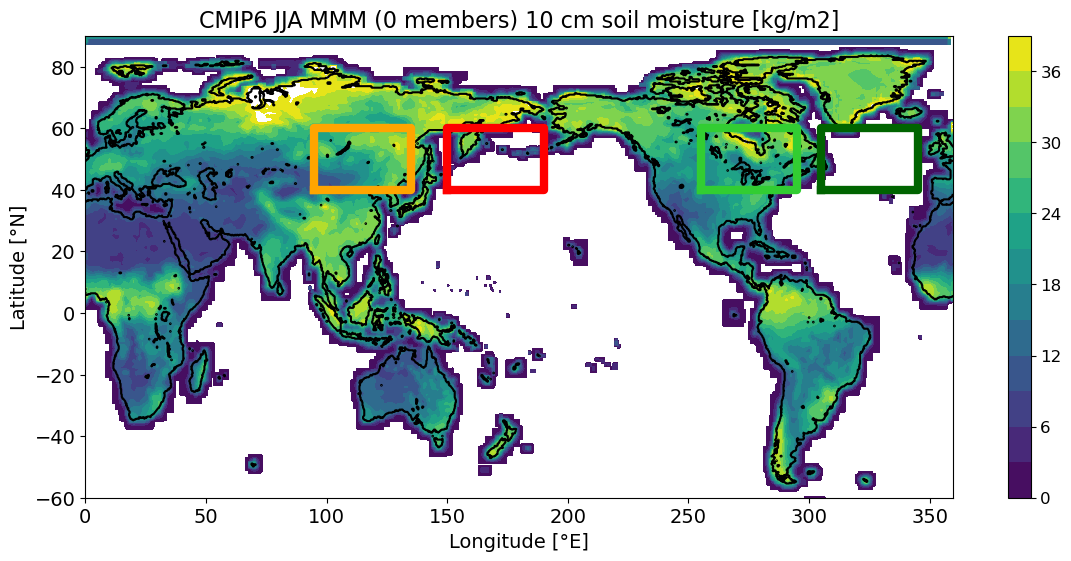

In [7]:
# Read the seasonal mean from the netcdf file.
d_mean_season_nc = xr.open_dataset(label_season + '_MMM_'+varname+'_single_member_'+time_window+'.nc')
#counter = d_mean_season_nc[varname_path].attrs['counter']
mean_seasonal = d_mean_season_nc[varname_path]#.values/counter

# Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_seasonal,levels=levels)#,cmap='RdYlBu')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

# Compute the LSC
"""
anom_A = d_mean_season_nc[varname_path].sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_B = d_mean_season_nc[varname_path].sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_C = d_mean_season_nc[varname_path].sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_D = d_mean_season_nc[varname_path].sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
LSC_pac = anom_B-anom_A
LSC_atl = anom_D-anom_C
"""

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

if varname=='tas':
    plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) '+description+' ['+units+f'], LSC_pac={LSC_pac:.2f} '+ units+f', LSC_atl={LSC_atl:.2f} '+ units,fontsize=16)
else:
    plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')

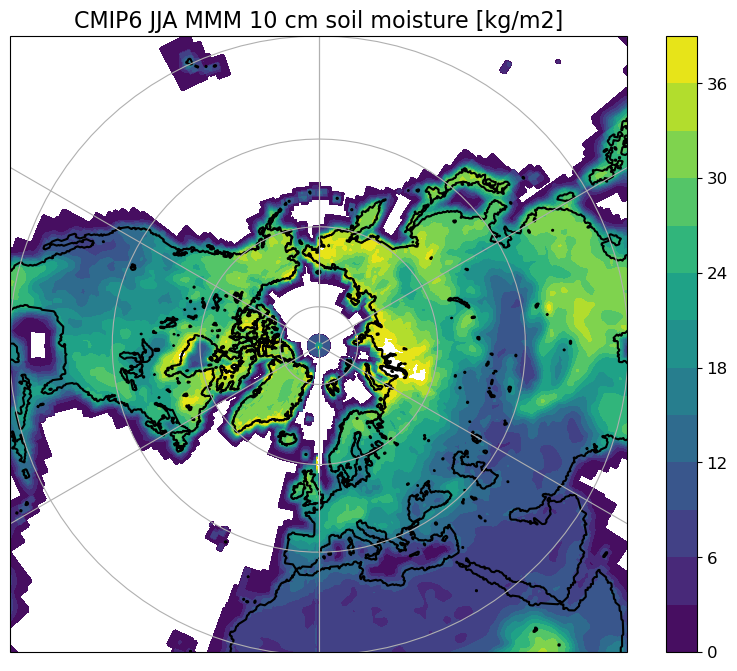

In [8]:
# Same figure for the NH only.

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
pc = ax1.contourf(lon,lat,mean_seasonal,transform=ccrs.PlateCarree(),levels=levels)
cf = ax1.contour(lon,lat,seamask,colors='k',levels=[0.5],transform=ccrs.PlateCarree())
#plt.xlabel('Longitude [°E]',fontsize=14)
#plt.ylabel('Latitude [°N]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)
ax1.gridlines()
ax1.set_title('CMIP6 ' + label_season + ' MMM '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_'+label_season+'_'+time_window+'_single_member_nps.png',bbox_inches='tight')

In [ ]:
# Plot the histograms of LSC computed as the difference between tos and tsl over the boxes defined above.

varname_save = 'tos-tsl'
time_window = '1979-2008'
#label_season = 'DJF'

tsl_anomalies = pd.read_csv('anomalies_'+label_season+'_tsl.csv')
tos_anomalies = pd.read_csv('anomalies_'+label_season+'_tos.csv')

list_model_tsl = tsl_anomalies.effective_models.tolist()
list_model_tos = tos_anomalies.effective_models.tolist()

list_both = [idx for idx in list_model_tsl if idx in list_model_tos]

LSC_pac_list= []
LSC_atl_list = []

for mod in list_both:
    delta_pac = tos_anomalies.B_list[list_model_tos.index(mod)]-(tsl_anomalies.A_list[list_model_tsl.index(mod)]-273.15)
    LSC_pac_list.append(delta_pac)
    delta_atl = tos_anomalies.D_list[list_model_tos.index(mod)]-(tsl_anomalies.C_list[list_model_tsl.index(mod)]-273.15)
    LSC_atl_list.append(delta_atl)

In [ ]:
# Plot the histograms of the LSC in both basins. Here we are considering tas.
fig = plt.figure(figsize=(7,6))

plt.hist(np.array(LSC_pac_list),bins=6,alpha=.5)
plt.hist(np.array(LSC_atl_list),bins=6,alpha=.5)

mean_lsc_pac = np.nanmean(np.array(LSC_pac_list))
mean_lsc_atl = np.nanmean(np.array(LSC_atl_list))
std_lsc_pac = np.nanstd(np.array(LSC_pac_list))
std_lsc_atl = np.nanstd(np.array(LSC_atl_list))

plt.xlabel('LSC [K]',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.tick_params(axis='both',labelsize=14)

plt.legend([f'Pac: {mean_lsc_pac:.2f}$\pm${std_lsc_pac:.2f} K',
            f'Atl: {mean_lsc_atl:.2f}$\pm${std_lsc_atl:.2f} K'],fontsize=14)
plt.title('CMIP6 ' + label_season + ' LSC pdf, '+ time_window,fontsize=16)

plt.savefig('lsc_pdf_'+varname_save+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')

In [ ]:
# Compute the standard deviation (as a map) - NOT IMPLEMENTED FOR TOS!!!

d_mean_season_nc = xr.open_dataset(label_season + '_MMM_'+varname+'_single_member_'+time_window+'.nc')
counter = d_mean_season_nc[varname_path].attrs['counter']
mean_seasonal = d_mean_season_nc[varname_path].values/counter

time_window = '1979-2008'
counter = 0
first_field = 1

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv('~/02.mmm_mmbias_single_member/'+label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]

    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files = sorted(os.listdir(path2files))
        if list_of_files: # Check whether there are output files to be read.
            print(path2members)
            print(member)

            first_file = 1 
            for ll in range(len(list_of_files)):
                filename = list_of_files[ll]
                final_date = filename[-9:-3]
                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                    da = xr.open_dataset(path2files + filename)
                    
                    # Read the variable of interest, so that the reading is faster.
                    if varname=='z500': # Select the variable at the right pressure level.
                        da_var = da['zg'].sel(plev=50000,method='nearest')
                    elif varname=='z200':
                        da_var = da['zg'].sel(plev=20000,method='nearest')
                    else:
                        da_var = da[varname]

                    if first_file:
                        db = da_var
                        first_file = 0
                    else:
                        db = xr.concat([db,da_var],dim='time')

            # Select the time window according to the type of time axis.
            if db.time.dtype=='datetime64[ns]':
                instant_start = np.datetime64('1979-01-01')
                instant_end = np.datetime64('2008-12-31')
            else:
                if db.time.values[0].calendar=='noleap':
                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.DatetimeNoLeap(2008,12,31,0,0,0,0,has_year_zero=True)
                elif db.time.values[0].calendar=='360_day':
                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                    instant_end = cftime.Datetime360Day(2008,12,17,0,0,0,0,has_year_zero=False)     

            # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.

            if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                
                if first_field:
                    d_mean4MMSTD_seasonal = (d_season_i - mean_seasonal)**2
                    first_field=0
                else:
                    d_mean4MMSTD_seasonal += (d_season_i - mean_seasonal)**2
                counter += 1
        print('----------')

print('Number of members actually used in total: '+ str(counter))

In [ ]:
mmstd_seasonal = np.sqrt(d_mean4MMSTD_seasonal.values/counter)

# Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mmstd_seasonal)#,levels=levels)#,cmap='RdYlBu')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)
"""
# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

# Compute the LSC
anom_A = d_mean_season_nc[varname_path].sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_B = d_mean_season_nc[varname_path].sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_C = d_mean_season_nc[varname_path].sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_D = d_mean_season_nc[varname_path].sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
LSC_pac = anom_B-anom_A
LSC_atl = anom_D-anom_C
"""
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 ' + label_season + ' MMSTD ('+str(counter)+' members) '+description+' ['+units+'], '+time_window,fontsize=16)
plt.savefig('mmstd_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')

In [ ]:
# Now do the same analysis taking data from the future scenario SSP5-8.5.
# Consider the same list of models as in 02.mmm_mmbias_single_member, so that the link with the mrsos models can be easily done.
# Compute the seasonal mean considering only the models used for the mrsos MMM.
label_season = 'JJA'
time_window = '2071-2100'
counter = 0
first_field = 1

A_list = []
B_list = []
C_list = []
D_list = []
effective_models = []
soil_depth_coord = []
soil_depth_value = []

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv('~/02.mmm_mmbias_single_member/'+label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    past_path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]
    path2members = past_path2members.replace('historical','ssp585').replace('CMIP/','ScenarioMIP/')

    if os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gr/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gr/latest/'
    elif os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gr1/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gr1/latest/'
    elif os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gn/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files_etal = sorted(os.listdir(path2files))
        # Select only the files that end with 'nc'.
        list_of_files = [idx for idx in list_of_files_etal if idx[-2:].lower() == 'nc'.lower()]

        if list_of_files: # Check whether there are output files to be read.
            print(path2members)
            print(member)

            first_file = 1 
            for ll in range(len(list_of_files)):
                filename = list_of_files[ll]
                final_date = filename[-9:-3]
                if int(final_date)>207101: # Here the instant_start is re-written in the form of YYYYMM.
                    da = xr.open_dataset(path2files + filename)

                    if varname=='t1m':
                        # Get the coordinate of the depth of the soil layer and save its value.
                        coord_list = []
                        for key in da.coords:
                            coord_list.append(key)
    
                        print(coord_list)
                        for cc in range(len(coord_list)):
                            if len(coord_list)>4:
                                isdepth=4
                            else:
                                if coord_list[cc]!='lon' and coord_list[cc]!='lat' and coord_list[cc]!='time':
                                    isdepth = cc                    
                        
                        soil_depth_coord.append(coord_list[isdepth])
                        soil_depth_value.append(da[coord_list[isdepth]].values)
                    
                    # Read the variable of interest, so that the reading is faster.
                    if varname=='z500': # Select the variable at the right pressure level.
                        da_var = da['zg'].sel(plev=50000,method='nearest')
                    elif varname=='z200':
                        da_var = da['zg'].sel(plev=20000,method='nearest')
                    elif varname=='tsl':
                        da_var = da[varname][:,0,:,:] # Select the upper level.
                    elif varname=='t1m': # Soil temperature interpolated at 1m depth.
                        sds = da[coord_list[isdepth]].values # Select soil depth coordinate
                        #print(coord_list[isdepth]) 
                        #print(sds)
                        jj = np.argmin(np.abs(sds-1))
                        sds[jj]
                        if sds[jj]<1:
                            j0 = jj # upper layer (above 1 m)
                            j1 = jj+1 # lower layer (below 1m)
                        else:
                            j0 = jj-1
                            j1 = jj
                        print(j0,j1)
                        tj0 = da['tsl'][:,j0,:,:]
                        tj1 = da['tsl'][:,j1,:,:]
                        dt = tj1-tj0
                        dz = sds[j1]-sds[j0]
                        
                        da_var = tj0 + (1-sds[j0])*dt/dz # linear interpolation of soil temperature at 1m depth.
                        #print(da_var)
                    else:
                        da_var = da[varname]

                    if first_file:
                        db = da_var
                        first_file = 0
                    else:
                        db = xr.concat([db,da_var],dim='time')

            # Select the time window according to the type of time axis.
            if db.time.dtype=='datetime64[ns]':
                instant_start = np.datetime64('2071-01-01')
                instant_end = np.datetime64('2100-12-31')
            else:
                if db.time.values[0].calendar=='noleap':
                    instant_start = cftime.DatetimeNoLeap(2071,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.DatetimeNoLeap(2100,12,31,0,0,0,0,has_year_zero=True)
                elif db.time.values[0].calendar=='360_day':
                    instant_start = cftime.Datetime360Day(2071,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.Datetime360Day(2100,12,17,0,0,0,0,has_year_zero=True)     

            # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
            if varname=='tos': # Ocean variables are on an irregular grid (often it is tripolar).   
                if len(d_season.dims)>1: # Skip the unstructured grid for now ###################################################
                    if model=='KACE-1-0-G':
                        d_season = d_season.rename({'lon':'old_lon','lat':'old_lat'})
                        d_season = d_season.rename({'longitude':'lon','latitude':'lat'})
                    else:
                        name_coordinates = np.array(d_season.coords).tolist() # Get the names of the coordinates.
                        #print(d_season.coords)
                        select_lat = [idx for idx in name_coordinates if 'lat' in idx]
                        name_lat = select_lat[0]
                        select_lon = [idx for idx in name_coordinates if 'lon' in idx]
                        name_lon = select_lon[0]
                        #name_lat = name_coordinates[0] 
                        #name_lon = name_coordinates[1]
                        d_season = d_season.rename({name_lon:'lon',name_lat:'lat'})
                    #print(d_season.coords)
                    regridder = xe.Regridder(d_season,ds_era5,"bilinear",ignore_degenerate=True)
                    d_season_i = regridder(d_season) # Interpolate.
                    if model=='GISS-E2-1-G':
                        d_season_i -= 273.15 # Convert K to degC, only for this model.
                    # ATTENTION!!! If this condition is not respected the d_season_i of the previous model is used!!!!!!!!!!!!!!!!
                else:
                    print('===== This model has an unstructured grid =====')
                    print('===== We are using data from the previous one =====')
            else:
                d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.

            
            if np.sum(np.isnan(d_season_i.values))<nan_limit: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.

                if varname=='t1m':
                    # Drop the depth of the soil layer, so that we can concat all the models.
                    d_season_i = d_season_i.drop_vars(coord_list[isdepth])
                    #d_month_i = d_month_i.drop_vars(coord_list[isdepth])
                elif varname=='mrsos':
                    # Drop the depth of the soil layer, so that we can concat all the models.
                    coord_list = []
                    for key in d_season_i.coords:
                        coord_list.append(key)
                    print(coord_list)
                    if len(coord_list)>5:
                        d_season_i = d_season_i.drop_vars('depth')
                        #d_month_i = d_month_i.drop_vars('depth')
                                
                if first_field:
                    d_mean4MMM_seasonal = d_season_i
                    first_field=0
                else:
                    #d_mean4MMM_seasonal += d_season_i
                    #d_mean4MMM_seasonal = np.nansum(d_season_i,d_mean4MMM_seasonal)
                    d_mean4MMM_seasonal = xr.concat([d_mean4MMM_seasonal,d_season_i],'mod')
                counter += 1
                #print(d_season_i) # The depth of the first layer of soil is different in different models.
                
                #if first_field:
                #    d_mean4MMM_seasonal = d_season_i
                #    first_field=0
                #else:
                #    d_mean4MMM_seasonal += d_season_i
                #counter += 1
                
                # Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
                fig = plt.figure(figsize=(14,6))
                #pc = plt.contourf(lon,lat,d_season_i.values,levels=levels)#,cmap='RdYlBu')
                pc = plt.pcolormesh(lon,lat,d_season_i.values,vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
                #pc = plt.pcolormesh(lon,lat,d_season_i.values,cmap=cmap,shading='nearest')
                cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                # Plot the Portal et al. (2022) boxes
                plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
                plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
                plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
                plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

                plt.title(model+' ' + label_season + ' (1 member) '+description+' ['+units+']',fontsize=16)
                plt.savefig(model+'_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')
                
                # Compute the LSC for a given model
                if varname=='tos': # For 'tos', the method 'sel' works as the method 'isel', i.e. it considers the indices.
                    anom_A = get_anomaly_tos(d_season_i,ext_A)
                    anom_B = get_anomaly_tos(d_season_i,ext_B)
                    anom_C = get_anomaly_tos(d_season_i,ext_C)
                    anom_D = get_anomaly_tos(d_season_i,ext_D)
                else:
                    anom_A = d_season_i.sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    anom_B = d_season_i.sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    anom_C = d_season_i.sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                    anom_D = d_season_i.sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values
                A_list.append(anom_A)
                B_list.append(anom_B)
                C_list.append(anom_C)
                D_list.append(anom_D)
                effective_models.append(model)
                print(anom_A,anom_B,anom_C,anom_D)

        print('----------')

print('Number of members actually used in total: '+ str(counter))

In [ ]:
# Save the values of the anomalies in the four areas of interest. This can be used to compute the LSC and some statistics.

dict = {'effective_models': effective_models, 'A_list': A_list, 'B_list': B_list, 'C_list': C_list, 'D_list': D_list,}  
df = pd.DataFrame(dict)
     
# saving the dataframe
df.to_csv('anomalies_'+label_season+'_'+varname+'_'+time_window+'.csv')

df

In [ ]:
# Save the seasonal MMM as netcdf file.
d_mean_season = d_mean4MMM_seasonal.mean(skipna=True,axis=0)
d_mean_season.to_netcdf(label_season + '_MMM_'+varname+'_single_member_'+time_window+'.nc')

In [ ]:
# Read the seasonal mean from the netcdf file.
d_mean_season_nc = xr.open_dataset(label_season + '_MMM_'+varname+'_single_member_'+time_window+'.nc')
#counter = d_mean_season_nc[varname_path].attrs['counter']
mean_seasonal = d_mean_season_nc[varname_path].values#/counter

# Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_seasonal,levels=levels)#,cmap='RdYlBu')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

# Compute the LSC
anom_A = d_mean_season_nc[varname_path].sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_B = d_mean_season_nc[varname_path].sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_C = d_mean_season_nc[varname_path].sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_D = d_mean_season_nc[varname_path].sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
LSC_pac = anom_B-anom_A
LSC_atl = anom_D-anom_C

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

if varname=='tas':
    plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) '+description+' ['+units+f'], LSC_pac={LSC_pac:.2f} '+ units+f', LSC_atl={LSC_atl:.2f} '+ units,fontsize=16)
else:
    plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')

In [ ]:
# Same figure for the NH only.

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
pc = ax1.contourf(lon,lat,mean_seasonal,transform=ccrs.PlateCarree(),levels=levels)
cf = ax1.contour(lon,lat,seamask,colors='k',levels=[0.5],transform=ccrs.PlateCarree())
#plt.xlabel('Longitude [°E]',fontsize=14)
#plt.ylabel('Latitude [°N]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)
ax1.gridlines()
ax1.set_title('CMIP6 ' + label_season + ' MMM '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_'+label_season+'_'+time_window+'_single_member_nps.png',bbox_inches='tight')

In [ ]:
# Plot the histograms of LSC computed as the difference between tos and tsl over the boxes defined above.
varname_save = 'tos-tsl'
time_window = '2071-2100'
#label_season='JJA'

tsl_anomalies = pd.read_csv('anomalies_'+label_season+'_tsl_'+time_window+'.csv')
tos_anomalies = pd.read_csv('anomalies_'+label_season+'_tos_'+time_window+'.csv')

list_model_tsl = tsl_anomalies.effective_models.tolist()
list_model_tos = tos_anomalies.effective_models.tolist()

list_both = [idx for idx in list_model_tsl if idx in list_model_tos]

LSC_pac_list= []
LSC_atl_list = []

for mod in list_both:
    delta_pac = tos_anomalies.B_list[list_model_tos.index(mod)]-(tsl_anomalies.A_list[list_model_tsl.index(mod)]-273.15)
    LSC_pac_list.append(delta_pac)
    delta_atl = tos_anomalies.D_list[list_model_tos.index(mod)]-(tsl_anomalies.C_list[list_model_tsl.index(mod)]-273.15)
    LSC_atl_list.append(delta_atl)

In [ ]:
# Plot the histograms of the LSC in both basins.
fig = plt.figure(figsize=(7,6))

plt.hist(np.array(LSC_pac_list),bins=6,alpha=.5)
plt.hist(np.array(LSC_atl_list),bins=6,alpha=.5)

mean_lsc_pac = np.mean(np.array(LSC_pac_list))
mean_lsc_atl = np.mean(np.array(LSC_atl_list))
std_lsc_pac = np.std(np.array(LSC_pac_list))
std_lsc_atl = np.std(np.array(LSC_atl_list))

plt.xlabel('LSC [K]',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.tick_params(axis='both',labelsize=14)

plt.legend([f'Pac: {mean_lsc_pac:.2f}$\pm${std_lsc_pac:.2f} K',
            f'Atl: {mean_lsc_atl:.2f}$\pm${std_lsc_atl:.2f} K'],fontsize=14)
plt.title('CMIP6 ' + label_season + ' LSC pdf, '+ time_window,fontsize=16)
plt.savefig('lsc_pdf_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')

In [ ]:
# Plot the histograms of LSC computed as the difference between tos and tsl over the boxes defined above.
# Consider past and future in the same figure.

varname_save = 'tos-tsl'
label_season = 'DJF'

tsl_anomalies_p = pd.read_csv('anomalies_'+label_season+'_tsl.csv')
tos_anomalies_p = pd.read_csv('anomalies_'+label_season+'_tos.csv')
list_model_tsl_p = tsl_anomalies_p.effective_models.tolist()
list_model_tos_p = tos_anomalies_p.effective_models.tolist()

list_both_p = [idx for idx in list_model_tsl_p if idx in list_model_tos_p]
LSC_pac_list_p = []
LSC_atl_list_p = []

for mod in list_both_p:
    delta_pac_p = tos_anomalies_p.B_list[list_model_tos_p.index(mod)]-(tsl_anomalies_p.A_list[list_model_tsl_p.index(mod)]-273.15)
    LSC_pac_list_p.append(delta_pac_p)
    delta_atl_p = tos_anomalies_p.D_list[list_model_tos_p.index(mod)]-(tsl_anomalies_p.C_list[list_model_tsl_p.index(mod)]-273.15)
    LSC_atl_list_p.append(delta_atl_p)
    
tsl_anomalies_f = pd.read_csv('anomalies_'+label_season+'_tsl_2071-2100.csv')
tos_anomalies_f = pd.read_csv('anomalies_'+label_season+'_tos_2071-2100.csv')
list_model_tsl_f = tsl_anomalies_f.effective_models.tolist()
list_model_tos_f = tos_anomalies_f.effective_models.tolist()

list_both_f = [idx for idx in list_model_tsl_f if idx in list_model_tos_f]
LSC_pac_list_f = []
LSC_atl_list_f = []

for mod in list_both_f:
    delta_pac_f = tos_anomalies_f.B_list[list_model_tos_f.index(mod)]-(tsl_anomalies_f.A_list[list_model_tsl_f.index(mod)]-273.15)
    LSC_pac_list_f.append(delta_pac_f)
    delta_atl_f = tos_anomalies_f.D_list[list_model_tos_f.index(mod)]-(tsl_anomalies_f.C_list[list_model_tsl_f.index(mod)]-273.15)
    LSC_atl_list_f.append(delta_atl_f)
    
# Plot the histograms    
fig = plt.figure(figsize=(7,6))

plt.hist(np.array(LSC_pac_list_p),bins=6,alpha=1,color='C0',histtype=u'step',linewidth=3)
plt.hist(np.array(LSC_atl_list_p),bins=6,alpha=1,color='C1',histtype=u'step',linewidth=3)
plt.hist(np.array(LSC_pac_list_f),bins=6,alpha=.5,color='C0')
plt.hist(np.array(LSC_atl_list_f),bins=6,alpha=.5,color='C1')

mean_lsc_pac_p = np.mean(np.array(LSC_pac_list_p))
mean_lsc_atl_p = np.mean(np.array(LSC_atl_list_p))
std_lsc_pac_p = np.std(np.array(LSC_pac_list_p))
std_lsc_atl_p = np.std(np.array(LSC_atl_list_p))
mean_lsc_pac_f = np.mean(np.array(LSC_pac_list_f))
mean_lsc_atl_f = np.mean(np.array(LSC_atl_list_f))
std_lsc_pac_f = np.std(np.array(LSC_pac_list_f))
std_lsc_atl_f = np.std(np.array(LSC_atl_list_f))

plt.xlabel('LSC [K]',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.tick_params(axis='both',labelsize=14)

plt.legend([f'Pac, past: {mean_lsc_pac_p:.2f}$\pm${std_lsc_pac_p:.2f} K',
            f'Atl, past: {mean_lsc_atl_p:.2f}$\pm${std_lsc_atl_p:.2f} K',
            f'Pac, future: {mean_lsc_pac_f:.2f}$\pm${std_lsc_pac_f:.2f} K',
            f'Atl, future: {mean_lsc_atl_f:.2f}$\pm${std_lsc_atl_f:.2f} K'],fontsize=14,loc=(1.04, 0))

plt.title('CMIP6 ' + label_season + ' LSC pdf',fontsize=16)
plt.savefig('lsc_pdf_'+varname+'_'+label_season+'_past-and-future_single_member.png',bbox_inches='tight')

In [ ]:
############# Correlate this with the mrsos over the same areas!!!!!!!!!!!!

In [ ]:
# Compute the std.

time_window = '2071-2100'
counter = 0
first_field = 1

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv('~/02.mmm_mmbias_single_member/'+label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    past_path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]
    path2members = past_path2members.replace('historical','ssp585').replace('CMIP/','ScenarioMIP/')

    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files = sorted(os.listdir(path2files))
        if list_of_files: # Check whether there are output files to be read.
            print(path2members)
            print(member)

            first_file = 1 
            for ll in range(len(list_of_files)):
                filename = list_of_files[ll]
                final_date = filename[-9:-3]
                if int(final_date)>207101: # Here the instant_start is re-written in the form of YYYYMM.
                    da = xr.open_dataset(path2files + filename)
                    # Read the variable of interest, so that the reading is faster.
                    if varname=='z500': # Select the variable at the right pressure level.
                        da_var = da['zg'].sel(plev=50000,method='nearest')
                    elif varname=='z200':
                        da_var = da['zg'].sel(plev=20000,method='nearest')
                    else:
                        da_var = da[varname]

                    if first_file:
                        db = da_var
                        first_file = 0
                    else:
                        db = xr.concat([db,da_var],dim='time')

            # Select the time window according to the type of time axis.
            if db.time.dtype=='datetime64[ns]':
                instant_start = np.datetime64('2071-01-01')
                instant_end = np.datetime64('2100-12-31')
            else:
                if db.time.values[0].calendar=='noleap':
                    instant_start = cftime.DatetimeNoLeap(2071,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.DatetimeNoLeap(2100,12,31,0,0,0,0,has_year_zero=True)
                elif db.time.values[0].calendar=='360_day':
                    instant_start = cftime.Datetime360Day(2071,1,1,0,0,0,0,has_year_zero=False)
                    instant_end = cftime.Datetime360Day(2100,12,17,0,0,0,0,has_year_zero=False)     

            # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.

            if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                if first_field:
                    d_mean4MMSTD_seasonal = (d_season_i - mean_seasonal)**2
                    first_field=0
                else:
                    d_mean4MMSTD_seasonal += (d_season_i - mean_seasonal)**2
                counter += 1
        print('----------')

print('Number of members actually used in total: '+ str(counter))

In [ ]:
mmstd_seasonal = np.sqrt(d_mean4MMSTD_seasonal.values/counter)

# Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mmstd_seasonal)#,levels=levels)#,cmap='RdYlBu')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)
"""
# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

# Compute the LSC
anom_A = d_mean_season_nc[varname_path].sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_B = d_mean_season_nc[varname_path].sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_C = d_mean_season_nc[varname_path].sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
anom_D = d_mean_season_nc[varname_path].sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter
LSC_pac = anom_B-anom_A
LSC_atl = anom_D-anom_C
"""
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 ' + label_season + ' MMSTD ('+str(counter)+' members) '+description+' ['+units+'], '+time_window,fontsize=16)
plt.savefig('mmstd_'+varname+'_'+label_season+'_'+time_window+'_single_member.png',bbox_inches='tight')

In [ ]:
# For each model we should compute the LSC_pac and LSC_atl and evaluate their pdf.

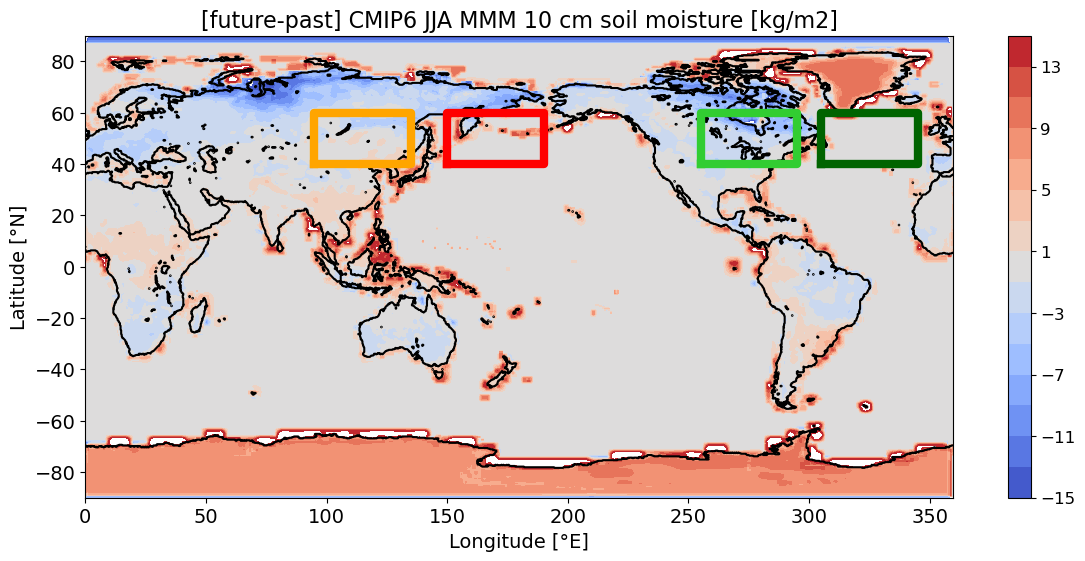

In [9]:
# Now plot the future-present seasonal tas mean.

d_mean_season_nc_future = xr.open_dataset(label_season + '_MMM_'+varname+'_single_member_2071-2100.nc')
#counter_future = d_mean_season_nc_future[varname_path].attrs['counter']
mean_seasonal_future = d_mean_season_nc_future[varname_path].values#/counter_future

d_mean_season_nc_past = xr.open_dataset(label_season + '_MMM_'+varname+'_single_member_1979-2008.nc')
#counter_past = d_mean_season_nc_past[varname_path].attrs['counter']
mean_seasonal_past = d_mean_season_nc_past[varname_path].values#/counter_past

# Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_seasonal_future-mean_seasonal_past,np.arange(-15,17,2),cmap='coolwarm')
cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
#plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

# Plot the Portal et al. (2022) boxes
plt.plot([ext_A[0],ext_A[1],ext_A[1],ext_A[0],ext_A[0]],[ext_A[2],ext_A[2],ext_A[3],ext_A[3],ext_A[2]],'orange',linewidth=6)
plt.plot([ext_B[0],ext_B[1],ext_B[1],ext_B[0],ext_B[0]],[ext_B[2],ext_B[2],ext_B[3],ext_B[3],ext_B[2]],'red',linewidth=6)
plt.plot([ext_C[0],ext_C[1],ext_C[1],ext_C[0],ext_C[0]],[ext_C[2],ext_C[2],ext_C[3],ext_C[3],ext_C[2]],'limegreen',linewidth=6)
plt.plot([ext_D[0],ext_D[1],ext_D[1],ext_D[0],ext_D[0]],[ext_D[2],ext_D[2],ext_D[3],ext_D[3],ext_D[2]],'darkgreen',linewidth=6)

# Compute the LSC
"""
anom_Af = d_mean_season_nc_future[varname_path].sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_future
anom_Ap = d_mean_season_nc_past[varname_path].sel(longitude=slice(ext_A[0],ext_A[1]),latitude=slice(ext_A[3],ext_A[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_past
anom_Bf = d_mean_season_nc_future[varname_path].sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_future
anom_Bp = d_mean_season_nc_past[varname_path].sel(longitude=slice(ext_B[0],ext_B[1]),latitude=slice(ext_B[3],ext_B[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_past
anom_Cf = d_mean_season_nc_future[varname_path].sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_future
anom_Cp = d_mean_season_nc_past[varname_path].sel(longitude=slice(ext_C[0],ext_C[1]),latitude=slice(ext_C[3],ext_C[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_past
anom_Df = d_mean_season_nc_future[varname_path].sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_future
anom_Dp = d_mean_season_nc_past[varname_path].sel(longitude=slice(ext_D[0],ext_D[1]),latitude=slice(ext_D[3],ext_D[2])).mean('longitude',skipna=True).mean('latitude',skipna=True).values/counter_past
LSC_pac = anom_Bf-anom_Bp-anom_Af+anom_Ap
LSC_atl = anom_Df-anom_Dp-anom_Cf+anom_Cp
"""
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

if varname=='tas':
    plt.title('[future-past] CMIP6 ' + label_season + ' MMM '+description+' ['+units+f'], LSC_pac={LSC_pac:.2f} '+ units+f', LSC_atl={LSC_atl:.2f} '+ units,fontsize=16)
else:
    plt.title('[future-past] CMIP6 ' + label_season + ' MMM '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_future-past_'+varname+'_'+label_season+'_single_member.png',bbox_inches='tight')

In [ ]:
# Same plot over the NH only.

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
#pc = ax1.contourf(lon,lat,mean_seasonal_future-mean_seasonal_past,np.arange(-22,26,4),cmap='coolwarm',transform=ccrs.PlateCarree())
pc = ax1.pcolor(lon,lat,mean_seasonal_future-mean_seasonal_past,transform=ccrs.PlateCarree())
cf = ax1.contour(lon,lat,seamask,colors='k',levels=[0.5],transform=ccrs.PlateCarree())
#plt.xlabel('Longitude [°E]',fontsize=14)
#plt.ylabel('Latitude [°N]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)
ax1.gridlines()
ax1.set_title('[future-past] CMIP6 ' + label_season + ' MMM '+description+' ['+units+']',fontsize=16)

plt.savefig('mmm_future-past_'+varname+'_'+label_season+'_single_member_nps.png',bbox_inches='tight')

In [ ]:
# In Greenland and Antarctica (where the is ice on land) there future-past tsl difference is nan, because in some model it is nan.
# 1) The delta tsl that we have used in the SPEEDY forcing (over Greenland) is, thus, a numerical typo;
# 2) Look at the delta tsl in those models that have actual values of tsl: in principle we expect small values of delta tsl in those regions
# 3) we might want to consider the nanmean also to avoid the gaps near the zero longitude!

In [ ]:
def read_var(path2files,list_of_files,str_start,varname,label_season):
    """
    Function to extract the d_season_i from a given model and member.
    """
    print(path2members)
    print(member)

    first_file = 1

    if str_start=='2071-01-01':
        yyyymm_start = 207101
        str_end = '2100-12-31'
        yyyy_start = 2071
        m_start = 1
        d_start = 1
        yyyy_end = 2100
        m_end = 12
        d_end = 17
    elif str_start=='1979-01-01':
        yyyymm_start = 197901
        str_end = '2008-12-31'
        yyyy_start = 1979
        m_start = 1
        d_start = 1
        yyyy_end = 2008
        m_end = 12
        d_end = 17
        
    for ll in range(len(list_of_files)):
        filename = list_of_files[ll]
        final_date = filename[-9:-3]
        if int(final_date)>yyyymm_start:
            da = xr.open_dataset(path2files + filename)
            # Read the variable of interest, so that the reading is faster.
            if varname=='z500': # Select the variable at the right pressure level.
                da_var = da['zg'].sel(plev=50000,method='nearest')
            elif varname=='z200':
                da_var = da['zg'].sel(plev=20000,method='nearest')
            elif varname=='tsl':
                da_var = da[varname][:,0,:,:] # Select the upper level.
            else:
                da_var = da[varname]

            if first_file:
                db = da_var
                first_file = 0
            else:
                db = xr.concat([db,da_var],dim='time')

    # Select the time window according to the type of time axis.
    if db.time.dtype=='datetime64[ns]':
        instant_start = np.datetime64(str_start)
        instant_end = np.datetime64(str_end)
    else:
        if db.time.values[0].calendar=='noleap':
            instant_start = cftime.DatetimeNoLeap(yyyy_start,m_start,d_start,0,0,0,0,has_year_zero=True)
            instant_end = cftime.DatetimeNoLeap(yyyy_end,m_end,d_end,0,0,0,0,has_year_zero=True)
        elif db.time.values[0].calendar=='360_day':
            instant_start = cftime.Datetime360Day(yyyy_start,m_start,d_start,0,0,0,0,has_year_zero=True)
            instant_end = cftime.Datetime360Day(yyyy_end,m_end,d_end,0,0,0,0,has_year_zero=True)     

    # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
    d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
    d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
    if varname=='tos': # Ocean variables are on an irregular grid (often it is tripolar).   
        if len(d_season.dims)>1: # Skip the unstructured grid for now ###################################################
            if model=='KACE-1-0-G':
                d_season = d_season.rename({'lon':'old_lon','lat':'old_lat'})
                d_season = d_season.rename({'longitude':'lon','latitude':'lat'})
            else:
                name_coordinates = np.array(d_season.coords).tolist() # Get the names of the coordinates.
                #print(d_season.coords)
                select_lat = [idx for idx in name_coordinates if 'lat' in idx]
                name_lat = select_lat[0]
                select_lon = [idx for idx in name_coordinates if 'lon' in idx]
                name_lon = select_lon[0]
                #name_lat = name_coordinates[0] 
                #name_lon = name_coordinates[1]
                d_season = d_season.rename({name_lon:'lon',name_lat:'lat'})
            #print(d_season.coords)
            regridder = xe.Regridder(d_season,ds_era5,"bilinear",ignore_degenerate=True)
            d_season_i = regridder(d_season) # Interpolate.
            if model=='GISS-E2-1-G':
                d_season_i -= 273.15 # Convert K to degC, only for this model.
            # ATTENTION!!! If this condition is not respected the d_season_i of the previous model is used!!!!!!!!!!!!!!!!
        else:
            print('===== This model has an unstructured grid =====')
            print('===== We are using data from the previous one =====')
    else:
        d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.

    return d_season_i

In [ ]:
# Plot the future-past map for each model that we have in the future set.

counter = 0
first_field = 1

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv('~/02.mmm_mmbias_single_member/'+label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    past_path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]
    path2members = past_path2members.replace('historical','ssp585').replace('CMIP/','ScenarioMIP/')

    if os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gr/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gr/latest/'
    elif os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gr1/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gr1/latest/'
    elif os.path.exists(path2members + member + '/'+domain+'/'+varname_path+'/gn/latest/'):
        path2files = path2members + member + '/'+domain+'/'+varname_path+'/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files_etal = sorted(os.listdir(path2files))
        # Select only the files that end with 'nc'.
        list_of_files = [idx for idx in list_of_files_etal if idx[-2:].lower() == 'nc'.lower()]

        # We assume that if there are data in the future there are also in the past.
        # EC-Earth3-Veg has not saved the historical tsl.
        if model=='EC-Earth3-Veg':
            path2files_past = path2files.replace('ssp585','historical').replace('ScenarioMIP/','CMIP/')
        else:
            path2files_past = path2files.replace('ssp585','historical').replace('ScenarioMIP/','CMIP/')
            list_of_files_past = sorted(os.listdir(path2files_past))
        
        if list_of_files: # Check whether there are output files to be read.
            d_season_i = read_var(path2files,list_of_files,'2071-01-01',varname,label_season)
            if model=='EC-Earth3-Veg':
                d_season_i_past = d_season_i
            else:
                d_season_i_past = read_var(path2files_past,list_of_files_past,'1979-01-01',varname,label_season)
            
            if np.sum(np.isnan(d_season_i.values))<nan_limit: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                if first_field:
                    d_mean4MMM_seasonal = d_season_i-d_season_i_past
                    first_field=0
                else:
                    d_mean4MMM_seasonal += d_season_i-d_season_i_past
                counter += 1
                
                # Plot the seasonal mean and compute the LSC as in Portal et al. (2022).
                fig = plt.figure(figsize=(14,6))
                pc = plt.contourf(lon,lat,d_season_i.values-d_season_i_past.values,np.arange(-15,17,2),cmap='coolwarm')
                #pc = plt.pcolormesh(lon,lat,d_season_i.values,vmin=vmin,vmax=vmax,cmap=cmap,shading='nearest')
                #pc = plt.pcolormesh(lon,lat,d_season_i.values-d_season_i_past.values,cmap=cmap,shading='nearest')
                cf = plt.contour(lon,lat,seamask,colors='k',levels=[0.5])
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                plt.title(model+' ' + label_season + ' (1 member) '+description+' ['+units+']',fontsize=16)
                plt.savefig(model+'_delta_'+varname+'_'+label_season+'_single_member.png',bbox_inches='tight')
                
                effective_models.append(model)


        print('----------')

print('Number of members actually used in total: '+ str(counter))